# 專題分析- None

### ◉ Practice :  K-means / 階層式分群 / 凝聚分層分群 / DBSCAN

# 1.K-means

### 產生訓練資料

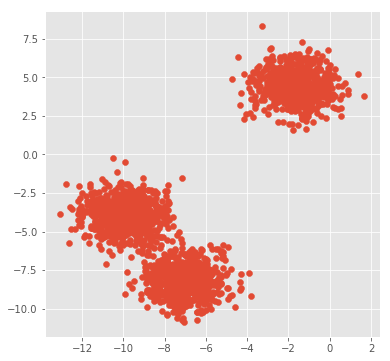

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
plt.style.use('ggplot')
%matplotlib inline

plt.figure(figsize=(6, 6))

n_samples = 2000
random_state = 1
X, y = make_blobs(n_samples=n_samples, random_state=random_state) #隨機產生集群

plt.scatter(X[:, 0], X[:, 1])

### 標準化 (使不同feature在計算距離時擁有相同的Scale，除非想保有不同feature的重要性才不用標準化)

In [2]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std = sc.fit_transform(X)

### K-means 訓練

In [3]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, init='k-means++')
y_pred = km.fit_predict(X_std)

### 將訓練結果以圖表顯示

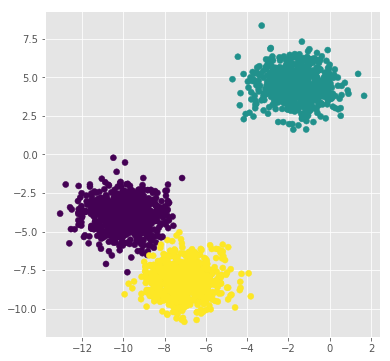

In [4]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

### 輪廓圖分析

In [5]:
km.labels_

array([1, 2, 0, ..., 0, 1, 1], dtype=int32)

### 輪廓係數 (Silhoutte Coefficient) 

In [6]:
# 平均輪廓係數
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_avg = silhouette_score(X_std, km.labels_)
print(silhouette_avg)

0.7063673031349995


In [7]:
# 各資料點輪廓係數
sample_silhouette_values = silhouette_samples(X_std, km.labels_)
sample_silhouette_values

array([0.89899834, 0.7146709 , 0.74045306, ..., 0.6618817 , 0.87211738,
       0.84017038])

### 輪廓圖

可參考：http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

In [8]:
##### 將Kmeans的相關作圖會用到的參數設定於此 #####
n_clusters = 3
cluster = km
cluster_labels = km.labels_
X = X_std

### 產生輪廓圖

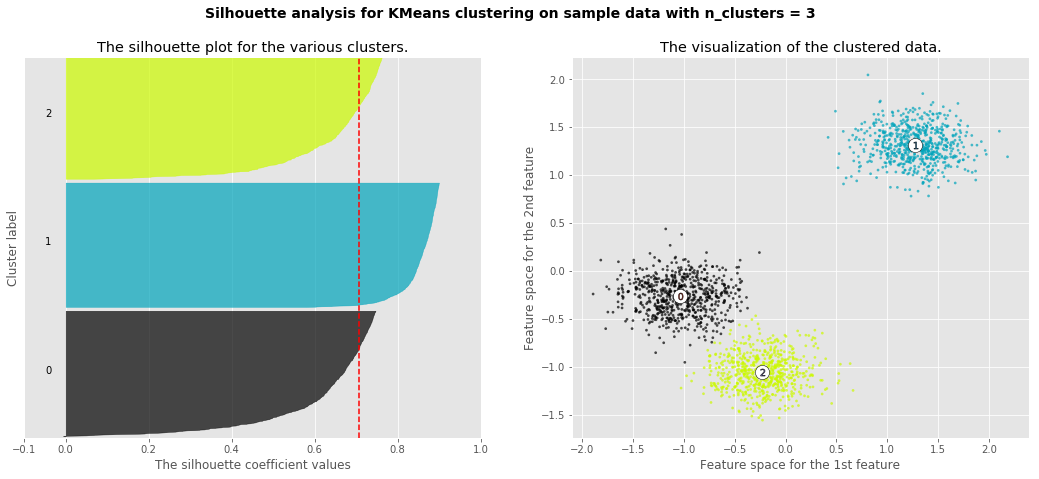

In [9]:
import matplotlib.cm as cm
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.set_xlim([-0.1, 1])
# (n_clusters+1)*10 是為了在輪廓圖中加上一些空白
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# 計算每個資料的輪廓係數
sample_silhouette_values = silhouette_samples(X, cluster_labels)
# 計算所有資料的輪廓係數平均
silhouette_avg = silhouette_score(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # 取出不同label的所有資料點輪廓係數，並由大至小排序
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    # 計算集群中共有幾個點
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    # 計算每個集群輪廓圖的上下界y位置
    y_upper = y_lower + size_cluster_i

    # 設定不同集群顏色
    color = cm.spectral(float(i) / n_clusters)
    # fill_betweenx 用來填充顏色
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                      facecolor=color, edgecolor=color, alpha=0.7)

    # 標註集群label
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # 計算下一個集群輪廓圖要畫的位置(+10 保留中間一些空白分隔)
    y_lower = y_upper + 20

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# 畫輪廓係數平均線
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


# 畫右側散佈分群圖
colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

# 標註散佈分群圖中集群名稱
centers = cluster.cluster_centers_
# 將集群中心以白圈顯示
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
# 加上中心點的數字
for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### tuning k

In [10]:
max_k = 10
sum_distance = []
for k in range(1,max_k+1):
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sum_distance.append(km.inertia_)

### 呈現結果

Text(0.5,0,'k')

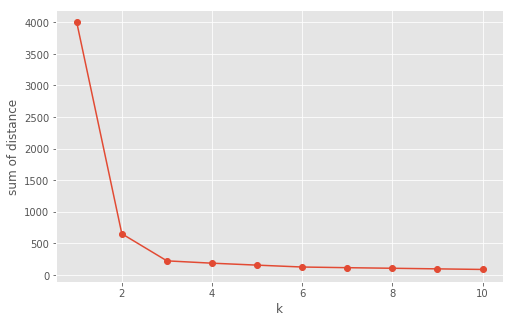

In [11]:
plt.figure(figsize=(8,5))
plt.plot(list(range(1,max_k+1)),sum_distance,'-o')
plt.ylabel('sum of distance')
plt.xlabel('k')

依據調教結果K值=3 分群結果會是較佳的建議值

# 2.階層式分群

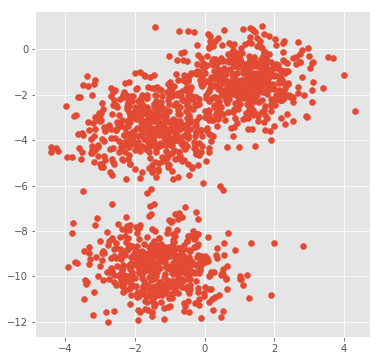

In [12]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
plt.style.use('ggplot')
%matplotlib inline

plt.figure(figsize=(6, 6))

n_samples = 1500
random_state = 2
X, y = make_blobs(n_samples=n_samples, random_state=random_state) #隨機產生集群

plt.scatter(X[:, 0], X[:, 1])

In [13]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std = sc.fit_transform(X)

### 凝聚分層分群 by Scikit-Learn

In [14]:
from sklearn.cluster import AgglomerativeClustering
aggc = AgglomerativeClustering(linkage='ward',n_clusters=3)
y_pred = aggc.fit_predict(X_std)

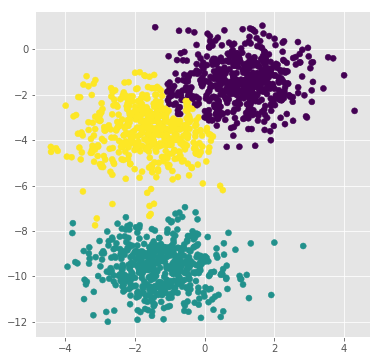

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

### 凝聚分層分群&階層樹狀圖 by Scipy

#### scipy.cluster.hierarchy.linkage
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
#### scipy.clustera.hierarchy.dendrogram
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html

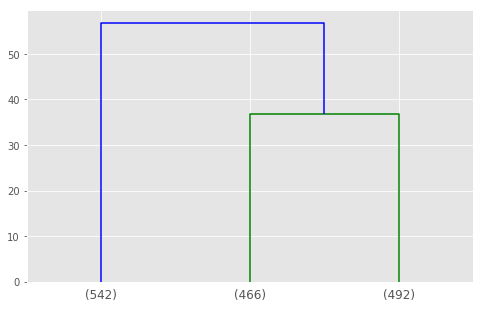

In [16]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(8, 5))
linkage_matrix = linkage(X_std, "ward")

# p: 集群數
# truncate_mode: 階層樹太大可讀性低，因此可以利用此參數裁剪
# show_leaf_counts: 顯示leaf分群數量
tree = dendrogram(linkage_matrix, p=3, truncate_mode='lastp', show_leaf_counts=True)

plt.show()

# DBSCAN

In [17]:
from sklearn import datasets
n_samples = 1500
X1, y1 = datasets.make_blobs(n_samples=n_samples, random_state=8)
X2, y2 = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
X3, y3 = datasets.make_moons(n_samples=n_samples, noise=.05)

In [18]:
sc = StandardScaler()
X1_std = sc.fit_transform(X1)
X2_std = sc.fit_transform(X2)
X3_std = sc.fit_transform(X3)

### 一般圓狀

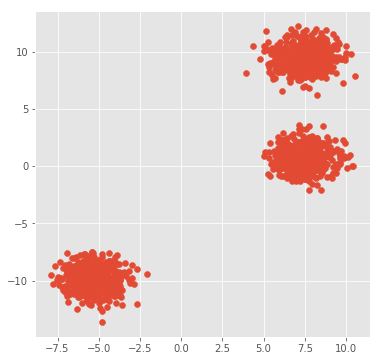

In [19]:
plt.figure(figsize=(6,6))
plt.scatter(X1[:, 0], X1[:, 1])

In [20]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=5)#可調整：eps(半徑)、min_samples(半徑內最少邊緣點數量)
y_pred_dbscan = dbscan.fit_predict(X1_std)

from sklearn.cluster import AgglomerativeClustering
aggc = AgglomerativeClustering(linkage='ward',n_clusters=3)
y_pred_aggc = aggc.fit_predict(X1_std)

from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
y_pred_km = km.fit_predict(X1_std)

Text(0.5,1,'KMeans')

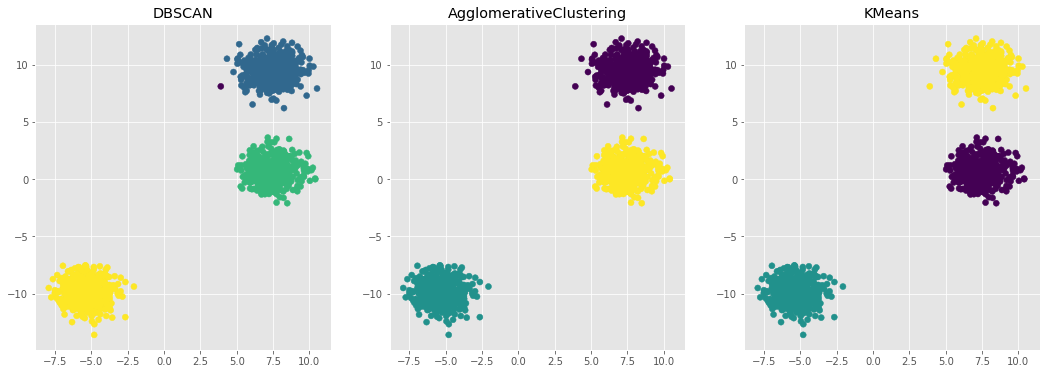

In [21]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.scatter(X1[:, 0], X1[:, 1], c=y_pred_dbscan)
plt.title('DBSCAN')

plt.subplot(132)
plt.scatter(X1[:, 0], X1[:, 1], c=y_pred_aggc)
plt.title('AgglomerativeClustering')

plt.subplot(133)
plt.scatter(X1[:, 0], X1[:, 1], c=y_pred_km)
plt.title('KMeans')

### 甜甜圈形

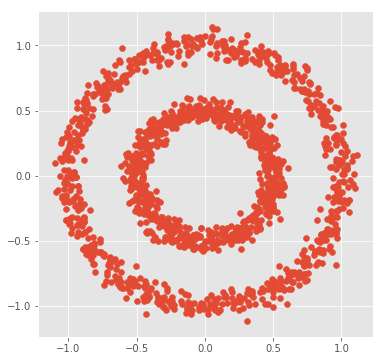

In [22]:
plt.figure(figsize=(6,6))
plt.scatter(X2[:, 0], X2[:, 1])

In [23]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=5)
y_pred_dbscan = dbscan.fit_predict(X2_std)

from sklearn.cluster import AgglomerativeClustering
aggc = AgglomerativeClustering(linkage='ward',n_clusters=3)
y_pred_aggc = aggc.fit_predict(X2_std)

from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
y_pred_km = km.fit_predict(X2_std)

Text(0.5,1,'KMeans')

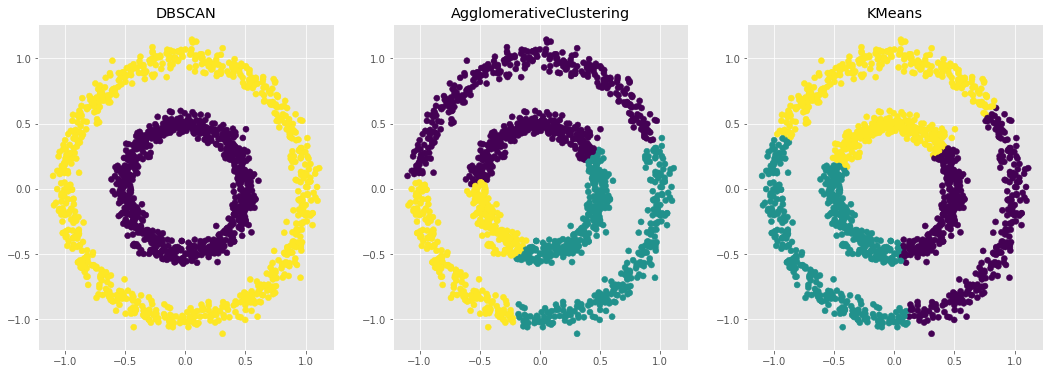

In [24]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.scatter(X2[:, 0], X2[:, 1], c=y_pred_dbscan)
plt.title('DBSCAN')

plt.subplot(132)
plt.scatter(X2[:, 0], X2[:, 1], c=y_pred_aggc)
plt.title('AgglomerativeClustering')

plt.subplot(133)
plt.scatter(X2[:, 0], X2[:, 1], c=y_pred_km)
plt.title('KMeans')

### 半月形

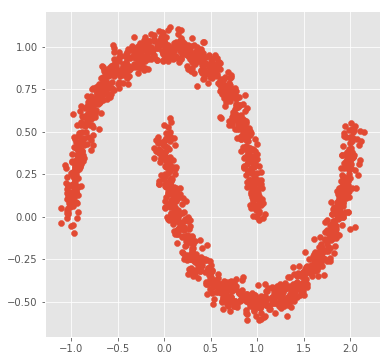

In [25]:
plt.figure(figsize=(6,6))
plt.scatter(X3[:, 0], X3[:, 1])

In [26]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=5)
y_pred_dbscan = dbscan.fit_predict(X3_std)

from sklearn.cluster import AgglomerativeClustering
aggc = AgglomerativeClustering(linkage='ward',n_clusters=3)
y_pred_aggc = aggc.fit_predict(X3_std)

from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
y_pred_km = km.fit_predict(X3_std)

Text(0.5,1,'KMeans')

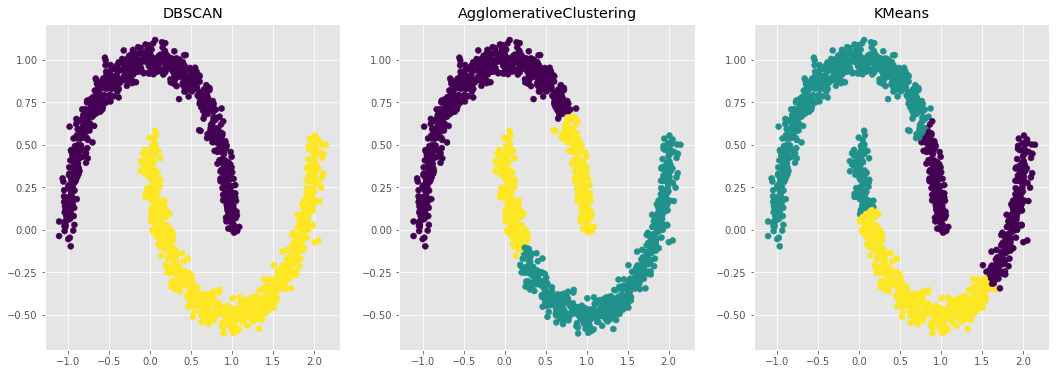

In [27]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.scatter(X3[:, 0], X3[:, 1], c=y_pred_dbscan)
plt.title('DBSCAN')

plt.subplot(132)
plt.scatter(X3[:, 0], X3[:, 1], c=y_pred_aggc)
plt.title('AgglomerativeClustering')

plt.subplot(133)
plt.scatter(X3[:, 0], X3[:, 1], c=y_pred_km)
plt.title('KMeans')